# SEG Tutorial - Coulored Inversion on F3 seismic section

________

### In this tutorial, we implement a simple version of the Coloured Inversion algorithm proposed by Lancaster et Whitcombe (2000) in python.

_________________________________

### In order to display graphs inline in the notebook

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lasio  # easy work with well logs LAS files
import os
import pandas as pd

### The dataset
For this example, we use the dGB Earth Sciences, OpendTect F3 Dataset from which we recovered one well AI log and a vertical seismic 2D panel collocated with the F02-1 well log. There is also an AI cube that was apparently (info received by Matt from a dGB employee) generated with a commercial software using a model-based constrained inversion with hard constraints.

Let's display a section of this AI cube to get an idea of where we want to get with our workflow.

In [2]:
win_up = 408
win_down = 1136
time_IP = np.arange(win_up, win_down+1, 4)  # time window of cube in opendtect project
IP_section = np.loadtxt('Ai_inline362_horizons.dat')
panel_IP = (IP_section[:, 2:]).T
xbin = (IP_section[:, 1])



### Putting the panel IP in a DataFrame to plot wihtout the NaN in imshow

In [3]:
xi, ti = np.meshgrid(xbin, time_IP)

In [4]:
IP_section = pd.DataFrame()
IP_section['X'] = xi.ravel()
IP_section['t'] = ti.ravel()
IP_section['IP_open'] = panel_IP.ravel()
IP_section.replace(1e30, np.nan, inplace=True)  # 1e30 are NaN in project
id_nan = IP_section.IP_open.isnull()  # This will be useful later to plot our result with the same shape
IP_section = IP_section.set_index(['X', 't'])
IP_section = IP_section.unstack(level='X')

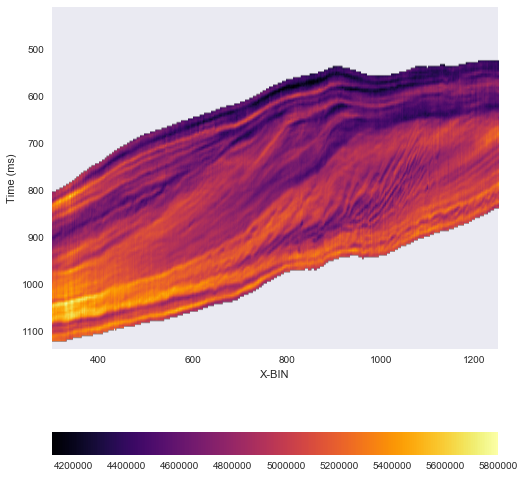

In [5]:
with sns.axes_style("dark"):
    fig, (ax) = plt.subplots(figsize=(8, 10))
image = ax.imshow(IP_section.IP_open, extent=[np.min(xbin), np.max(xbin), np.max(time_IP),
                                              np.min(time_IP)], cmap='inferno')
ax.axis([np.min(xbin), np.max(xbin), np.max(time_IP), np.min(time_IP)])
ax.set_xlabel('X-BIN')
ax.set_ylabel('Time (ms)')
cbar = plt.colorbar(image, orientation='horizontal');

#### Some code to extract top and bottom horizon. This will prove to be useful later to plot and compare

In [6]:
top = [time_IP[np.where(panel_IP[:,col]<1e30)[0][0]-1] for col in range(panel_IP.shape[1])]
bot = [time_IP[np.where(panel_IP[:,col]<1e30)[0][-1]+1] for col in range(panel_IP.shape[1])]

### Beginning of the workflow

1.	Fit a function to the well log power spectrum
2.	Get difference spectrum by substracting the seismic power spectrum from it
3.	Convert the difference spectrum to an operator
4.	Convolute the stacked seismic with the operator
5.	QC – check the residuals by comparing log and AI section power spectrum

### Using lasio library, we start by reading all the logs of the F3 project

In [7]:
Logs = pd.DataFrame()
temp = pd.DataFrame()
las_files=[]
for f in os.listdir('All_wells_RawData/Lasfiles/'):
    if f.endswith('.las'):
        las_files.append(f)
        
for las in las_files:
    well = lasio.read('All_wells_RawData/Lasfiles/' + las,encoding='utf-8')
    logs_param = []
    temp=pd.DataFrame()
    for curve in well.curves:
        try:
            temp['ID'] = las[:5]
            temp[curve.mnemonic]=well[curve.mnemonic]
        except:
            pass
    if las == las_files[0]:   
        Logs = temp.copy()
    else:
        Logs=pd.concat([Logs,temp],axis=0)
Logs.head(n=5)

,ID,DEPTH,RHOB,DT,GR,AI,AI_rel,PHIE
0,F02-1,48.00,NaN,524.0485,NaN,3820257.00,-455.6956,NaN
1,F02-1,48.15,NaN,524.0410,NaN,3820311.75,-455.6956,NaN
2,F02-1,48.30,NaN,524.0336,NaN,3820366.25,-455.6956,NaN
3,F02-1,48.45,NaN,524.0262,NaN,3820419.75,-455.6956,NaN
4,F02-1,48.60,NaN,524.0190,NaN,3820472.25,-455.6956,NaN


### We start by looking at only one IP log collocated with the seismic data 2D section we are planning to use (F02-1).
For convenience, we just keep AI and depth as seperate arrays from the grouped DataFrame

In [8]:
grouped = Logs.groupby('ID')
AI_f021 = (grouped.get_group('F02-1').AI).values
depth_f021 = (grouped.get_group('F02-1').DEPTH).values

### Let's plot AI log on F02-1 as a function of depth see what it looks like

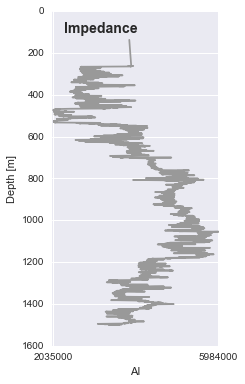

In [9]:
color_list = ['#999999','#2166ac','#b2182b']
my_palette = sns.color_palette(color_list)
sns.set_palette(my_palette)
fig,ax1 = plt.subplots(figsize=(3,6))

ax1.plot(AI_f021[600:],depth_f021[600:])
ax1.text(2300000,100,'Impedance',fontsize=14,
        fontweight='semibold')
ax1.set_xlabel('AI')
ax1.set_ylabel('Depth [m]')
ax1.invert_yaxis()
ax1.set_xticks([np.floor(np.min(AI_f021)/1000)*1000,np.ceil(np.max(AI_f021)/1000)*1000]);

### Convert Depth >> Time
Before working in the Fourier domain, we need to convert the log in the time domain. From the F3 project, we get the TD info as txt, get an interpolation function and apply it to the depth info

In [10]:
TD = np.loadtxt('All_wells_RawData/DT_model/F02-1_TD.txt')

### Using scipy.interpolate to simply interpolate linearly the time-depth function

In [11]:
from scipy.interpolate import interp1d
f_td = interp1d(TD[:,1],TD[:,0],kind='linear')
time_f021 = f_td(depth_f021)

### We generate the power spectrum in the Fourier domain

In [12]:
n_log = AI_f021.shape[0] #number of samples
k_log=np.arange(n_log-1)
Fs_log = 1/np.diff(time_f021/1000) #Getting sampled frequencies
T_log = n_log/Fs_log
freq_log = k_log/T_log
freq_log = freq_log[range(n_log//2)] # one side frequency range
spec_log = np.fft.fft(AI_f021)/n_log # fft computing and normalization
spec_log = spec_log[range(n_log//2)]

### We now plot AI log along with the power spectrum

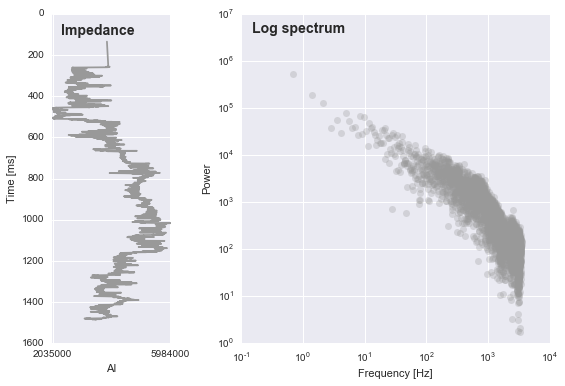

In [13]:
color_list = ['#999999','#2166ac','#b2182b']
my_palette = sns.color_palette(color_list)
sns.set_palette(my_palette)
fig=plt.figure()
ax1 = plt.subplot2grid((1,3),(0,0))
ax2 = plt.subplot2grid((1,3),(0,1),colspan=3)

ax1.plot(AI_f021[600:],time_f021[600:])
ax1.text(2300000,100,'Impedance',fontsize=14,
        fontweight='semibold')
ax1.set_xlabel('AI')
ax1.set_ylabel('Time [ms]')
ax1.invert_yaxis()
ax1.set_xticks([np.floor(np.min(AI_f021)/1000)*1000,np.ceil(np.max(AI_f021)/1000)*1000])

ax2.set_ylabel('Power')
ax2.set_xlabel('Frequency [Hz]')
ax2.plot(freq_log,np.abs(spec_log),'o',alpha=0.3)
ax2.text(0.15,4e6,'Log spectrum',fontsize=14,
        fontweight='semibold')
ax2.set_yscale('log')
ax2.set_xscale('log')

fig.tight_layout()

### We can now approximate the well log AI power spectrum by a continuous function. We use a simple linear model (in log scale) with a negative slope. Simple considerations to achieve it:
1. Creation of a function representing the model
2. Defining an objective function
3. We use scipy.optimize library
4. Least square approach

In [14]:
def my_fun(p,x):
    return p[0]*x**p[1]   

In [15]:
def err_fun(p,x,y):    
    return (np.log10(y) - np.log10(my_fun(p,x)))

#### We define our regression not over the entire data length, only fitting the first 2000 frequencies of the spectrum. This is a user choice that will influence our end result. Since the element at spec[2000] is a frequency of around 1500 Hz, we figure our model doesn't need to fit log frequencies beyond that.

In [16]:
from scipy import optimize
qout,success = optimize.leastsq(err_fun, [1e5,-0.8],args=(freq_log[1:2000],np.abs(spec_log[1:2000])),maxfev=3000)

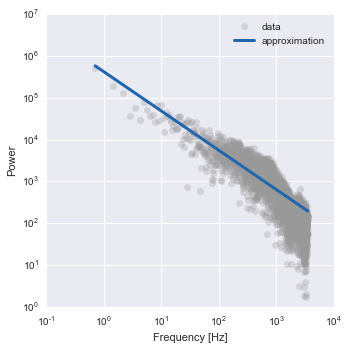

In [17]:
fig,ax1=plt.subplots(figsize=(5,5))

spec = ax1.plot(freq_log,np.abs(spec_log),'o',alpha=0.3)
approx = ax1.plot(freq_log[1:],my_fun(qout,freq_log[1:]),linewidth=3)
ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.set_ylabel('Power')
ax1.set_xlabel('Frequency [Hz]')
plt.legend(['data','approximation'],loc='best')
fig.tight_layout()
fig.savefig('Figures/Well_spectra_approx.png',dpi=400);

### In order to generate an relative AI section, we need a stacked seismic section.

In [18]:
data_read = np.loadtxt('export_inline362.ascii') # this ascii panel from F3 dataset was exported using opendtect
panel_seis = (data_read[:,2:]).T
time = np.arange(0,1852,4) #time sampling of the seismic data

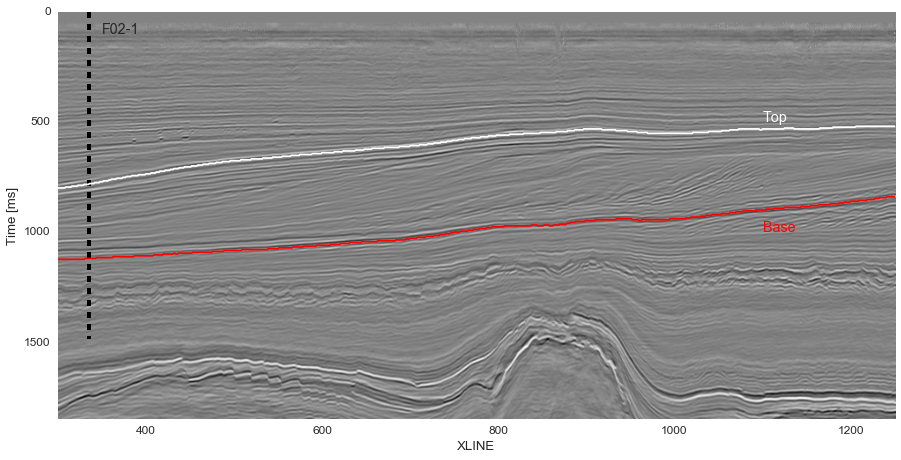

In [19]:
sns.set(font_scale=1.2)
sns.set_palette(my_palette)

with sns.axes_style("dark"): 
    fig,(ax) = plt.subplots(figsize=(15,10))

ax.imshow(panel_seis,extent=[np.min(xbin),np.max(xbin),np.max(time),np.min(time)],aspect=0.25,cmap='Greys',label='big')
ax.plot([336,336],[0,np.max(time_f021)],'k--',lw=4)#Just to display the well position
ax.plot(xbin,top,'w')
ax.plot(xbin,bot,'r')
ax.text(350,100,'F02-1')
ax.text(1100,500,'Top',color='w')
ax.text(1100,1000,'Base',color='r')

ax.set_ylim(np.max(time),np.min(time))
ax.set_xlim(np.min(xbin),np.max(xbin))
ax.set_xlabel('XLINE')
ax.set_ylabel('Time [ms]');

### We now need to calculate the seismic power spectrum around the well location 
1. We calculate a mean trace
2. We do the Fourier transform

The mean is calculated usign a user-defined window both for time and the number of seismic traces

In [20]:
min_time = 50
max_time=250
xmin =  26
xmax = 46
trace = np.mean(panel_seis[min_time:max_time,xmin:xmax],axis=1)

### We repeat the procedure to calculate the power spectrum

In [21]:
Fs_seis = 1/0.004 #sec
n_seis=len(trace)
k_seis=np.arange(n_seis)
T_seis= n_seis/Fs_seis
freq_seis = k_seis/T_seis
freq_seis = freq_seis[range(n_seis//2)] # one side frequency range

spec_seis = np.fft.fft(trace)/n_seis # fft computing and normalization
spec_seis = spec_seis[range(n_seis//2)]

# This is to smooth the spectrum over a window of 10
roll_win = np.ones(10)/10
spec_seis = np.convolve(spec_seis,roll_win,mode='same')

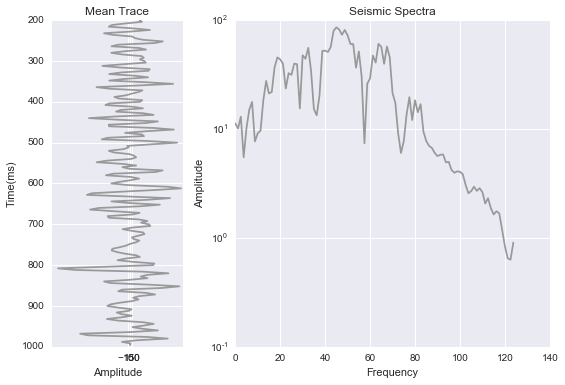

In [22]:
sns.set(font_scale=1)
sns.set_palette(my_palette)
fig=plt.figure()
ax1 = plt.subplot2grid((1,3),(0,0))
ax2 = plt.subplot2grid((1,3),(0,1),colspan=2)

ax1.plot(trace,time[min_time:max_time])
ax1.set_xlabel('Amplitude')
ax1.set_ylabel('Time(ms)')
ax1.invert_yaxis()
ax1.set_xticks([-150,0,150])
ax1.set_title('Mean Trace')
#ax1.set_xlim([-300,400])

ax2.set_ylabel('Amplitude')
ax2.set_xlabel('Frequency')
ax2.plot(freq_seis,np.abs(spec_seis))
ax2.set_title('Seismic Spectra')
ax2.set_yscale('log')
#ax2.set_xlim([0,200])
#ax2.set_ylim([0.1,50])

fig.tight_layout();

### We now compare seismic spectrum with the one from the AI log
We adjust the modelled log AI power spectrum to definied frequency boundaries with a taper.

In [23]:
spec_seis = spec_seis*100 #Since power spectrum is relative, we scale this one to compare to the log spectrum

x_tape_in = np.linspace(0,5,50)
x_tape_out = np.linspace(115,125,50)

y_tape_in = np.hanning(100)[:50]*my_fun(qout,x_tape_in[-1])
y_tape_out = np.hanning(100)[50:]*my_fun(qout,x_tape_out[0])

#### We limit our modelled frequency between 5 and 115Hz and append Hanning tapers at the begining (0-5Hz) and at the end (115-125 Hz)

In [24]:
id_seis = (freq_seis > 5) * (freq_seis < 115)
new_freq_log = np.hstack([x_tape_in,freq_seis[id_seis],x_tape_out])
new_spec_log = np.hstack([y_tape_in,my_fun(qout,freq_seis[id_seis]),y_tape_out])

### We plot the resulting power spectrum

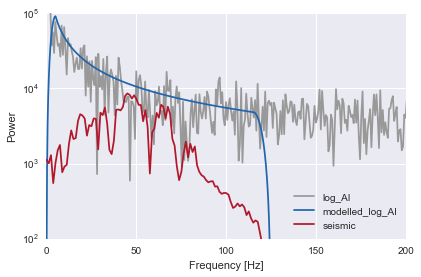

In [25]:
fig,ax = plt.subplots(figsize = (6,4))
ax.plot(freq_log,np.abs((spec_log)))
ax.plot(new_freq_log,new_spec_log)
ax.set_ylabel('Power')
ax.set_xlabel('Frequency [Hz]')
ax.plot(freq_seis,np.abs((spec_seis)))
ax.set_yscale('log')
ax.set_xlim([0,200])
ax.set_ylim([100,100000])
plt.legend(['log_AI','modelled_log_AI','seismic'], loc='best')
plt.tight_layout()

### We can now calculate the difference spectra and the resulting operator

In [26]:
f_log = interp1d(new_freq_log,new_spec_log,bounds_error=False,fill_value=0)
spec_log_seis_sample = f_log(freq_seis)
gap = (spec_log_seis_sample - spec_seis)

In [27]:
#fourier inverse to get the operator
operator1 = np.fft.ifft(np.abs(gap)) #we define operator 1-2-3 for plotting purposes
operator2 = np.fft.fftshift(operator1) #we move the operator to the center of the window
operator3 = operator2.imag #we take the quadrature part (90deg) of the operator
operator4 = operator2.T
operator=operator3

### We plot the difference between the two power spectrum and the resulting operator

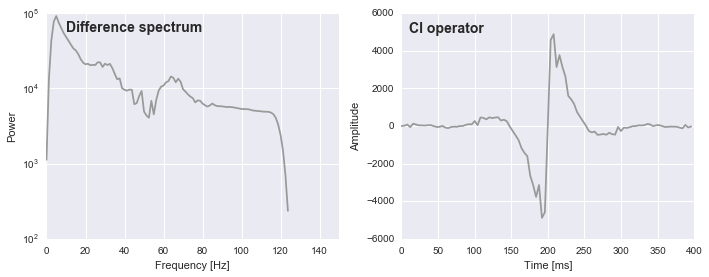

In [28]:
fig,(ax1,ax2) = plt.subplots(figsize = (10,4),ncols=2)
ax1.plot(freq_seis,np.abs(gap))
ax1.set_ylabel('Power')
ax1.set_xlabel('Frequency [Hz]')
ax1.text(10,57000,'Difference spectrum',fontsize=14,
        fontweight='semibold')
ax1.set_yscale('log')
ax1.set_xlim([0,150])
ax1.set_ylim([100,100000])

ax2.plot(np.arange(0,len(operator)*4,4),operator)
ax2.text(10,5000,'CI operator',fontsize=14,
        fontweight='semibold')
ax2.set_xlabel('Time [ms]')
ax2.set_ylabel('Amplitude')
fig.tight_layout()

#### Here we plot the different step from the gap to the final operator. 

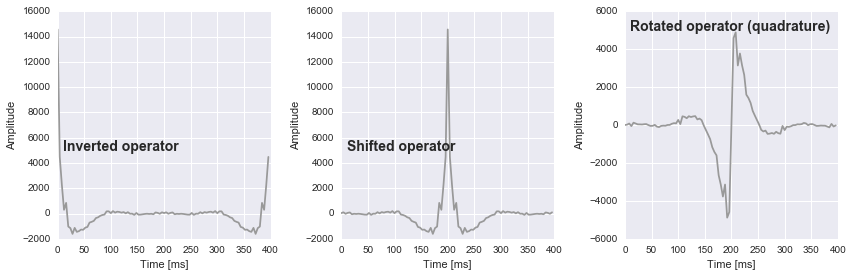

In [29]:
fig,(ax1,ax2,ax3) = plt.subplots(figsize = (12,4),ncols=3)
ax1.plot(np.arange(0,len(operator1)*4,4),operator1.real)
ax1.text(10,5000,'Inverted operator',fontsize=14,
        fontweight='semibold')
ax1.set_xlabel('Time [ms]')
ax1.set_ylabel('Amplitude')

ax2.plot(np.arange(0,len(operator2)*4,4),operator2.real)
ax2.text(10,5000,'Shifted operator',fontsize=14,
        fontweight='semibold')
ax2.set_xlabel('Time [ms]')
ax2.set_ylabel('Amplitude')
ax3.plot(np.arange(0,len(operator4)*4,4),operator3)
ax3.text(10,5000,'Rotated operator (quadrature)',fontsize=14,
        fontweight='semibold')
ax3.set_xlabel('Time [ms]')
ax3.set_ylabel('Amplitude')
fig.tight_layout();

### We define a function to make a convolution and apply it along an axis

In [30]:
def convolve(t):
    return np.convolve(t, operator, mode='same')

In [31]:
ci = np.apply_along_axis(convolve, axis=0, arr=panel_seis)

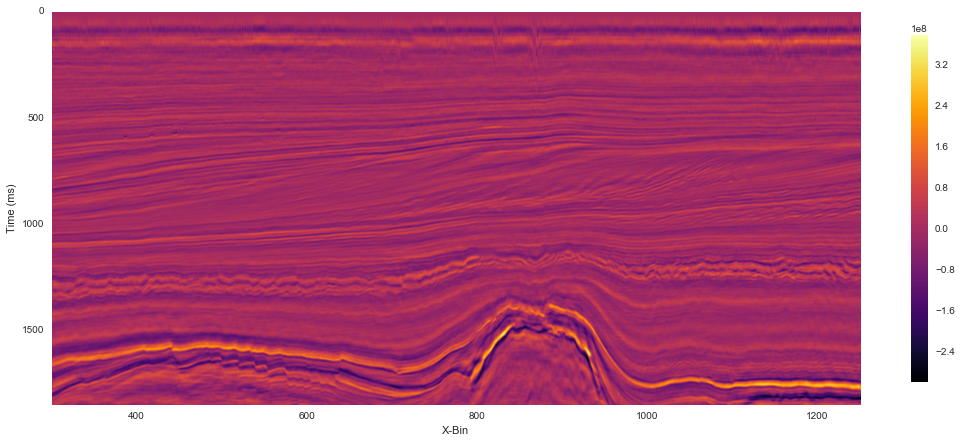

In [32]:
with sns.axes_style("dark"):
    fig,(ax) = plt.subplots(figsize=(15,10))
image=ax.imshow(ci,extent=[np.min(xbin),np.max(xbin),np.max(time),np.min(time)],
                aspect=0.25, cmap="inferno",interpolation='bilinear')
ax.set_xlabel('X-Bin')
ax.set_ylabel('Time (ms)')
ax.set_ylim(np.max(time),np.min(time))
ax.set_xlim(np.min(xbin),np.max(xbin))
cbar = plt.colorbar(image,shrink=0.5)
fig.tight_layout();

In [33]:
idx = (time>=win_up) & (time<=win_down)
IP_CI = pd.DataFrame()
IP_CI['X'] = xi.ravel()
IP_CI['t'] = ti.ravel()
IP_CI['IP_relative'] = ci[idx].ravel()
IP_CI.loc[id_nan,'IP_relative'] = np.nan
IP_CI['IP_scaled'] = (np.max(IP_CI.IP_relative)-IP_CI.IP_relative)/\
                                            (np.max(IP_CI.IP_relative)-np.min(IP_CI.IP_relative))
IP_CI = IP_CI.set_index(['X', 't'])
IP_CI = IP_CI.unstack(level='X')

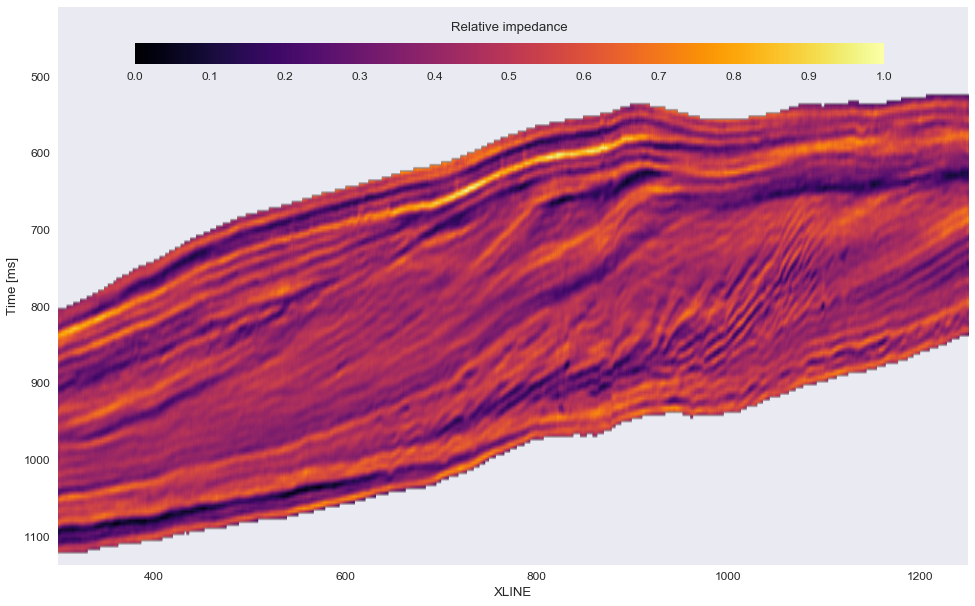

In [34]:
sns.set(font_scale=1.2)
with sns.axes_style("dark"):
    fig,(ax) = plt.subplots(figsize=(20,10))
image=ax.imshow(IP_CI.IP_scaled,
                extent=[np.min(xbin),np.max(xbin),np.max(time_IP),np.min(time_IP)],
                cmap='inferno',label='big',aspect=0.8)
ax.set_ylim(np.max(time_IP),np.min(time_IP))
ax.set_xlim(np.min(xbin),np.max(xbin))
ax.set_xlabel('XLINE')
ax.set_ylabel('Time [ms]')
cax = fig.add_axes([0.25, 0.82, 0.52, 0.03])
cbar = plt.colorbar(image,cax=cax,orientation='horizontal')
cbar.set_label(label='Relative impedance',labelpad=-60)

## Checking correspondance between CI power spectrum and the one modelled from the log
1. We calculate a mean AI trace from a buffer zone collocated with the log
2. We do the fft computation
3. We plot the scaled result

In [35]:
AI_trace = np.mean(ci[xmin:xmax,min_time:max_time],axis=0)

In [36]:
spec_AI = np.fft.fft(AI_trace)/n_seis # fft computing and normalization
spec_AI = spec_AI[range(n_seis//2)]
roll_win = np.ones(10)/10
spec_AI = np.convolve(spec_AI,roll_win,mode='same')

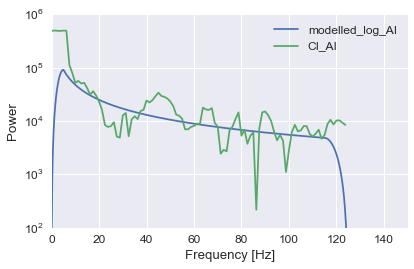

In [37]:
fig,ax = plt.subplots(figsize = (6,4))
ax.plot(new_freq_log,new_spec_log)
ax.set_ylabel('Power')
ax.set_xlabel('Frequency [Hz]')
ax.plot(freq_seis,np.abs((spec_AI)/4))# 4 is a scaling factor
# ax.set_title('Compared Spectra')
ax.set_yscale('log')
ax.set_xlim([0,150])
ax.set_ylim([100,1000000])
plt.legend(['modelled_log_AI','CI_AI'], loc='best')
plt.tight_layout()
fig.savefig('Figures/QC.png',dpi=400);